# Compare WG1 and WG3 historical emissions driven runs

- Working Group 1: 1750-2019 CEDS version 2020-09-11 for fossil and industrial, VUA historical + SSP2-4.5 for biomass burning
- Working Group 3: 1750-2014 CEDS version from Hoesly et al. (2018), VUA historical

Theme Song: Stained Silver<br>
Artist: Cave In<br>
Album: Antenna<br>
Released: 2003

In [1]:
import json
import numpy as np
from fair.constants import molwt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as st
import pandas as pd
from tqdm.notebook import tqdm
from multiprocessing import Pool
import random
import os
import copy

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from ar6.constants import NINETY_TO_ONESIGMA

from ar6.twolayermodel import TwoLayerModel

import datetime as dt
import scmdata
import matplotlib.pyplot as pl
import json
import fair

from scmdata.plotting import RCMIP_SCENARIO_COLOURS

<IPython.core.display.Javascript object>

In [2]:
with open('../data_output_large/fair-samples/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [3]:
scenarios = ['ssp119','ssp126','ssp245','ssp370']

In [4]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total['NMVOC']
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update
#new_ceds

emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
new_emissions = {}
for scenario in tqdm(scenarios):
    bc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|BC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    oc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|OC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    so2 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|Sulfur'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nh3 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NH3'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nmvoc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|VOC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    co = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    bc[:265] = emissions_ceds_update.loc[1750:2014,'BC'].values
    oc[:265] = emissions_ceds_update.loc[1750:2014,'OC'].values
    so2[:265] = emissions_ceds_update.loc[1750:2014,'SO2'].values
    nh3[:265] = emissions_ceds_update.loc[1750:2014,'NH3'].values
    nox[:265] = emissions_ceds_update.loc[1750:2014,'NOx'].values
    nmvoc[:265] = emissions_ceds_update.loc[1750:2014,'VOC'].values
    co[:265] = emissions_ceds_update.loc[1750:2014,'CO'].values
    bc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'BC'].values + np.linspace(0,0.8,5) * bc[265:270]
    oc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'OC'].values + np.linspace(0,0.8,5) * oc[265:270]
    so2[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'SO2'].values + np.linspace(0,0.8,5) * so2[265:270]
    nh3[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NH3'].values + np.linspace(0,0.8,5) * nh3[265:270]
    nox[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NOx'].values + np.linspace(0,0.8,5) * nox[265:270]
    nmvoc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'VOC'].values + np.linspace(0,0.8,5) * nmvoc[265:270]
    co[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'CO'].values + np.linspace(0,0.8,5) * co[265:270]
    
    new_emissions[scenario] = pd.DataFrame(
    {
        'BC': bc,
        'OC': oc,
        'SO2': so2,
        'NH3': nh3,
        'NOx': nox,
        'VOC': nmvoc,
        'CO': co
    })

  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
index = {
    5: 'SO2',
    6: 'CO',
    7: 'VOC',
    8: 'NOx',
    9: 'BC',
    10: 'OC',
    11: 'NH3'
}

new_emissions['ssp119'].loc[250:350,index[5]].values

array([108.52104741, 109.30119381, 108.76746995, 113.46173257,
       119.19142914, 124.39730103, 125.64091877, 124.27833608,
       120.62499699, 111.76477982, 107.86486206, 109.21403802,
       106.71700782, 101.5417518 ,  97.03202669,  91.07615229,
        89.07794354,  87.47481964,  86.63576902,  83.77641894,
        79.54915731,  75.2398318 ,  70.93050628,  66.62118076,
        62.31185525,  58.00252973,  53.69320421,  49.38387869,
        45.07455318,  40.76522766,  36.45590214,  35.17257184,
        33.88924154,  32.60591124,  31.32258094,  30.03925063,
        28.75592033,  27.47259003,  26.18925973,  24.90592943,
        23.62259912,  23.42317644,  23.22375375,  23.02433106,
        22.82490837,  22.62548569,  22.426063  ,  22.22664031,
        22.02721763,  21.82779494,  21.62837225,  21.53253014,
        21.43668802,  21.3408459 ,  21.24500379,  21.14916167,
        21.05331955,  20.95747744,  20.86163532,  20.76579321,
        20.66995109,  20.44359354,  20.217236  ,  19.99

In [6]:
years = np.arange(1750,2111)
startyear = 1750
first_scenyear = 2015
last_scenyear = 2110
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

species = [  # in fair 1.6, order is important
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

data_out = {}

for scen in scenarios:
    data_out[scen + '_WG1'] = np.ones((361, 40)) * np.nan
    data_out[scen + '_WG1'][:,0] = years

    years_future = [2015] + list(range(2020,2111,10))
    for i, specie in enumerate(species):
        if i<4 or i>10:
            data_out[scen + '_WG1'][:first_row,i+1] = emissions.loc[(emissions['Region']=='World')&(emissions['Scenario']==scen)&(emissions['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
            f = interp1d(years_future, emissions.loc[(emissions['Region']=='World')&(emissions['Scenario']==scen)&(emissions['Variable'].str.endswith(specie)),'2015':'2110'].dropna(axis=1))
            data_out[scen + '_WG1'][first_row:(last_row+1), i+1] = f(np.arange(first_scenyear, last_scenyear+1))*unit_convert[i+1]
        else:
            data_out[scen + '_WG1'][:,i+1] = new_emissions[scen].loc[:360,index[i+1]].values*unit_convert[i+1]

In [7]:
years = np.arange(1750,2111)
startyear = 1750
first_scenyear = 2015
last_scenyear = 2110
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

species = [  # in fair 1.6, order is important
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

for scen in scenarios:
    data_out[scen + '_WG3'] = np.ones((361, 40)) * np.nan
    data_out[scen + '_WG3'][:,0] = years

    years_future = [2015] + list(range(2020,2111,10))
    for i, specie in enumerate(species):
        data_out[scen + '_WG3'][:first_row,i+1] = emissions.loc[(emissions['Region']=='World')&(emissions['Scenario']==scen)&(emissions['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
        f = interp1d(years_future, emissions.loc[(emissions['Region']=='World')&(emissions['Scenario']==scen)&(emissions['Variable'].str.endswith(specie)),'2015':'2110'].dropna(axis=1))
        data_out[scen + '_WG3'][first_row:(last_row+1), i+1] = f(np.arange(first_scenyear, last_scenyear+1))*unit_convert[i+1]

In [8]:
results_out = {}

In [9]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

In [10]:
all_scenarios = ['ssp119_WG1', 'ssp126_WG1', 'ssp245_WG1', 'ssp370_WG1', 'ssp119_WG3', 'ssp126_WG3', 'ssp245_WG3', 'ssp370_WG3']

In [11]:
for scenario in tqdm(all_scenarios):
    updated_config = []
    for i, cfg in enumerate(config_list):
        updated_config.append({})
        for key, value in cfg.items():
            if isinstance(value, list):
                updated_config[i][key] = np.asarray(value)
            else:
                updated_config[i][key] = value
        updated_config[i]['emissions'] = data_out[scenario]
        updated_config[i]['diagnostics'] = 'AR6'
        updated_config[i]["efficacy"] = np.ones(45)
        updated_config[i]["gir_carbon_cycle"] = True
        updated_config[i]["temperature_function"] = "Geoffroy"
        updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
        updated_config[i]["fixPre1850RCP"] = False
        
    if __name__ == '__main__':
        with Pool(28) as pool:
            result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config), leave=False))
        
    result_t = np.array(result).transpose(1,2,0)
    
    results_out[scenario] = {}
    c, t, f_ant, f_aer, f_tot = result_t
    temp_rebase = t - t[245:265,:].mean(axis=0) + 0.85
    results_out[scenario]['temp'] = temp_rebase

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

In [12]:
ls = {
    'WG1': '-',
    'WG3': '--'
}

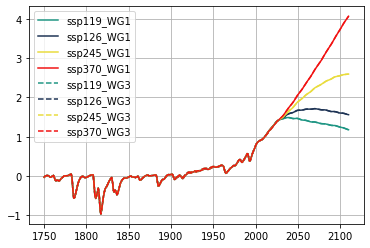

In [13]:
for scenario in all_scenarios:
    #pl.fill_between(np.arange(1750,2111), np.percentile(results_out[scenario]['temp'], 5, axis=1), np.percentile(results_out[scenario]['temp'], 95, axis=1))
    pl.plot(np.arange(1750,2111), np.percentile(results_out[scenario]['temp'], 50, axis=1), color=RCMIP_SCENARIO_COLOURS[scenario[:6]], ls=ls[scenario[-3:]], label=scenario)
    #pl.plot(temp_df.index, temp_df.temp, color='r')
pl.legend()
pl.grid()
#pl.xlim(1950,2000)
#pl.ylim(0,1)

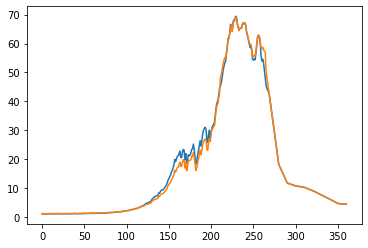

In [14]:
pl.plot(data_out['ssp119_WG1'][:,5])
pl.plot(data_out['ssp119_WG3'][:,5])

In [15]:
new_emissions['ssp119'].loc[250:350,index[5]].values

array([108.52104741, 109.30119381, 108.76746995, 113.46173257,
       119.19142914, 124.39730103, 125.64091877, 124.27833608,
       120.62499699, 111.76477982, 107.86486206, 109.21403802,
       106.71700782, 101.5417518 ,  97.03202669,  91.07615229,
        89.07794354,  87.47481964,  86.63576902,  83.77641894,
        79.54915731,  75.2398318 ,  70.93050628,  66.62118076,
        62.31185525,  58.00252973,  53.69320421,  49.38387869,
        45.07455318,  40.76522766,  36.45590214,  35.17257184,
        33.88924154,  32.60591124,  31.32258094,  30.03925063,
        28.75592033,  27.47259003,  26.18925973,  24.90592943,
        23.62259912,  23.42317644,  23.22375375,  23.02433106,
        22.82490837,  22.62548569,  22.426063  ,  22.22664031,
        22.02721763,  21.82779494,  21.62837225,  21.53253014,
        21.43668802,  21.3408459 ,  21.24500379,  21.14916167,
        21.05331955,  20.95747744,  20.86163532,  20.76579321,
        20.66995109,  20.44359354,  20.217236  ,  19.99

(1.0, 2.0)

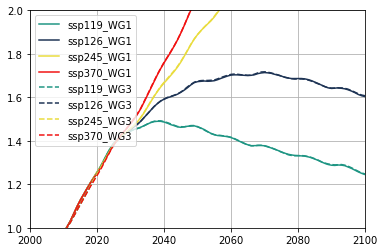

In [16]:
for scenario in all_scenarios:
    #pl.fill_between(np.arange(1750,2111), np.percentile(results_out[scenario]['temp'], 5, axis=1), np.percentile(results_out[scenario]['temp'], 95, axis=1))
    pl.plot(np.arange(1750,2111), np.percentile(results_out[scenario]['temp'], 50, axis=1), color=RCMIP_SCENARIO_COLOURS[scenario[:6]], ls=ls[scenario[-3:]], label=scenario)
    #pl.plot(temp_df.index, temp_df.temp, color='r')
pl.legend()
pl.grid()
pl.xlim(2000,2100)
pl.ylim(1,2)